In [40]:
%load_ext autoreload
%autoreload 2

import utilities
from evaluator import Evaluator
from embedder import Embedder
from embedder import Transformer
from embedder import Transformer_GNN
from embedder import Transformer_GNN_embedder
from embedder import Preprocessing_scaler
from Graph_generator import Graph_Generator
import tmp_generator as tmp
from visualizator import Visualizator

from eden import graph
import umap 

import numpy as np
from sklearn.decomposition import TruncatedSVD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate graphs + NO l.d.p.

In [190]:

n_graphs = 800

# 20 permutations
gg = Graph_Generator(n_graphs=n_graphs,degree = 4)

g1, na1, ea1 = gg.generate(22,30,30,1)
g2, na2, ea2 = gg.generate(22,30,30,10)

graphs, labels = gg.generate_set(g1,g2,na1, ea1,na2, ea2,30,30,plot=False)


# ldp
functions = [utilities.degree,utilities.clust_coefficient,utilities.local_degree_profile]
# no ldp
#functions = [utilities.degree,utilities.clust_coefficient]

graphs = utilities.add_info_to_nodes(graphs,functions)


max_n_nodes, n_attributes = utilities.find_shapes(graphs)
n_classes = len(np.unique(labels))

print("done")

done


In [191]:
graphs = tmp_preprocessing_vectorize(graphs)

In [192]:
# setting 

dim = [2]
times = 1


batch_size = 32
validation_split = 0.2
epochs_GNN = 1500
epochs_autoencoder = 10000
verbose=0
plot=False


patience_GNN = 150
patience_autoencoder = 500

## Embedder 1
### Spektral + PCA

In [193]:
my_GNN = tmp.generate_GNN(max_n_nodes,
                      n_attributes,
                      n_classes,
                      batch_size = batch_size,
                      validation_split = validation_split,
                      epochs = epochs_GNN,
                      patience = patience_GNN,
                      verbose = verbose, 
                      plot=plot)

m_1 = Transformer(my_GNN)
m_2 = Transformer(TruncatedSVD())
emb_1 = Embedder([m_1,m_2],"Spektral + PCA")

## Embedder 2
### Spektral + Small 128 - n_components

In [194]:
my_GNN_small = tmp.gen_gnn_small(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 patience = patience_GNN,
                                 dim = dim,
                                 plot = plot)

m_1 = Transformer(my_GNN_small)
emb_2 = Embedder([m_1],"Spektral + small")

## Embedder 3
### Spektral + Dense 128 - 64 - 32 - 16 -  8 - n_components

In [195]:
my_GNN_dense = tmp.gen_gnn_dense(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 dim = dim,
                                 patience = patience_GNN,
                                 plot = plot)

m_1 = Transformer(my_GNN_dense)
emb_3 = Embedder([m_1],"Spektral + dense")

## Embedder 4
### Spektral fino a 128 + Autoencoder 128 - 64- 16 - 8 - 5 - 3 - 2
### Preprocessing_scaler -0.5 ; 0.5

In [196]:
# modello 1 GNN
my_GNN = tmp.generate_GNN(max_n_nodes,n_attributes,n_classes,
                           batch_size=batch_size,
                           validation_split=validation_split,
                           verbose=verbose,
                           epochs=epochs_GNN,
                           patience= patience_GNN,
                           plot=plot)
m_1 = Transformer(my_GNN)

# preprocessing scaler
my_scaler = Preprocessing_scaler([0, 0.5])
# modello 2 Autoencoder
my_Autoencoder = tmp.gen_transf_autoencoder(batch_size=batch_size,
                                            validation_split=validation_split,
                                            epochs=epochs_autoencoder, 
                                            patience = patience_autoencoder,
                                            verbose=verbose,
                                            scaler=my_scaler,
                                            dim = dim,
                                            plot=plot)

m_2 = Transformer(my_Autoencoder)


emb_4 = Embedder([m_1,m_2], name="Spketral 128 - Autoencoder denso")

## Embedder 5
### Vectorize + pca 1000 + umap

In [197]:
vetcoriz = graph.Vectorizer(complexity = 5)
m_1= Transformer(vetcoriz, has_fit = False)
pca = TruncatedSVD(n_components=1000)
m_2 = Transformer(pca)
uma = umap.UMAP()
m_3 = Transformer(uma)

emb_5 = Embedder([m_1,m_2,m_3], name="Vectorize-5, PCA-1000, UMAP")

In [198]:
### 800 no ldp
emb = [emb_1,emb_2,emb_3,emb_4,emb_5]
vis_800_LDP = utilities.repeat_n_times(graphs, labels, emb , dim, 1,test_size=0.3,seed = 11)

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
599
	 	 	  Spektral + small
1179
	 	 	  Spektral + dense
694
	 	 	  Spketral 128 - Autoencoder denso
1292
3377
	 	 	  Vectorize-5, PCA-1000, UMAP


In [189]:
vis_1500_LDP.summary(std=False)
vis_1500_LDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.567   0.567
Spektral + small                  0.657   0.657
Spektral + dense                  0.628   0.628
Spketral 128 - Autoencoder denso  0.662   0.662
Vectorize-5, PCA-1000, UMAP       0.558   0.558
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      4       4
Spektral + small                    2       2
Spektral + dense                    3       3
Spketral 128 - Autoencoder denso    1       1
Vectorize-5, PCA-1000, UMAP         5       5


In [167]:
vis_1000_LDP.summary(std=False)
vis_1000_LDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.743   0.743
Spektral + small                  0.663   0.663
Spektral + dense                  0.706   0.706
Spketral 128 - Autoencoder denso  0.694   0.694
Vectorize-5, PCA-1000, UMAP       0.713   0.713
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      1       1
Spektral + small                    5       5
Spektral + dense                    3       3
Spketral 128 - Autoencoder denso    4       4
Vectorize-5, PCA-1000, UMAP         2       2


In [199]:
vis_800_LDP.summary(std=False)
vis_800_LDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.46    0.46
Spektral + small                  0.704   0.704
Spektral + dense                  0.666   0.666
Spketral 128 - Autoencoder denso  0.596   0.596
Vectorize-5, PCA-1000, UMAP       0.679   0.679
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      5       5
Spektral + small                    1       1
Spektral + dense                    3       3
Spketral 128 - Autoencoder denso    4       4
Vectorize-5, PCA-1000, UMAP         2       2


In [155]:
vis_500_LDP.summary(std=False)
vis_500_LDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.534   0.534
Spektral + small                  0.574   0.574
Spektral + dense                  0.574   0.574
Spketral 128 - Autoencoder denso  0.468   0.468
Vectorize-5, PCA-1000, UMAP       0.668   0.668
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      4       4
Spektral + small                    2       2
Spektral + dense                    3       3
Spketral 128 - Autoencoder denso    5       5
Vectorize-5, PCA-1000, UMAP         1       1


In [82]:
vis_1500_noLDP.summary(std=False)
vis_1500_noLDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.663   0.663
Spektral + small                  0.695   0.695
Spektral + dense                  0.591   0.591
Spketral 128 - Autoencoder denso  0.65    0.65
Vectorize-5, PCA-1000, UMAP       0.662   0.662
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      2       2
Spektral + small                    1       1
Spektral + dense                    5       5
Spketral 128 - Autoencoder denso    4       4
Vectorize-5, PCA-1000, UMAP         3       3


In [72]:
vis_1000_noLDP.summary(std=False)
vis_1000_noLDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.726   0.726
Spektral + small                  0.73    0.73
Spektral + dense                  0.751   0.751
Spketral 128 - Autoencoder denso  0.642   0.642
Vectorize-5, PCA-1000, UMAP       0.733   0.733
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      4       4
Spektral + small                    3       3
Spektral + dense                    1       1
Spketral 128 - Autoencoder denso    5       5
Vectorize-5, PCA-1000, UMAP         2       2


In [60]:
vis_800_noLDP.summary(std=False)
vis_800_noLDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.638   0.638
Spektral + small                  0.75    0.75
Spektral + dense                  0.763   0.763
Spketral 128 - Autoencoder denso  0.58    0.58
Vectorize-5, PCA-1000, UMAP       0.729   0.729
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      4       4
Spektral + small                    2       2
Spektral + dense                    1       1
Spketral 128 - Autoencoder denso    5       5
Vectorize-5, PCA-1000, UMAP         3       3


In [153]:
vis_500_noLDP.summary(std=False)
vis_500_noLDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.585   0.585
Spektral + small                  0.793   0.793
Spektral + dense                  0.629   0.629
Spketral 128 - Autoencoder denso  0.732   0.732
Vectorize-5, PCA-1000, UMAP       0.762   0.762
                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.534   0.534
Spektral + small                  0.574   0.574
Spektral + dense                  0.574   0.574
Spketral 128 - Autoencoder denso  0.468   0.468
Vectorize-5, PCA-1000, UMAP       0.668   0.668
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      5       5
Spektral + small                    1       1
Spektral + dense                    4       4
Spketral 128 - Autoencoder denso    3       3
Vectorize-5, PCA-1000, UMAP         2       2
      

In [62]:
vis_100_noLDP.summary(std=False)
vis_100_noLDP.rank()

                                      2    mean
--------------------------------  -----  ------
Spektral + PCA                    0.634   0.634
Spektral + small                  0.593   0.593
Spektral + dense                  0.637   0.637
Spketral 128 - Autoencoder denso  0.646   0.646
Vectorize-5, PCA-1000, UMAP       0.678   0.678
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      4       4
Spektral + small                    5       5
Spektral + dense                    3       3
Spketral 128 - Autoencoder denso    2       2
Vectorize-5, PCA-1000, UMAP         1       1


LDP


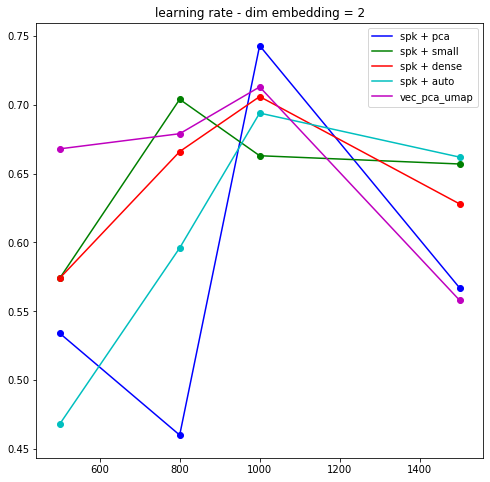

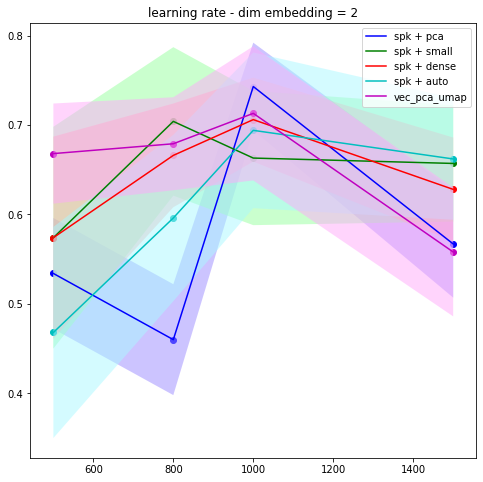

In [201]:
#visualizators = [vis_500_compx15, vis_800_compx15,vis_1000_compx15,vis_1000_compx15]
visualizators = [vis_500_LDP, vis_800_LDP,vis_1000_LDP,vis_1500_LDP]
print("LDP")
tmp_plot(visualizators, 2)
tmp_plot_std(visualizators, 2)

NO LDP


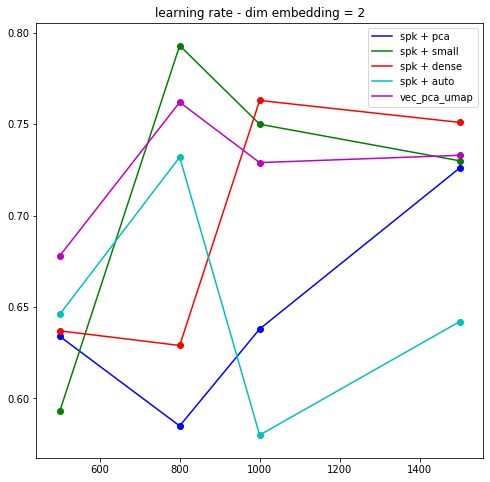

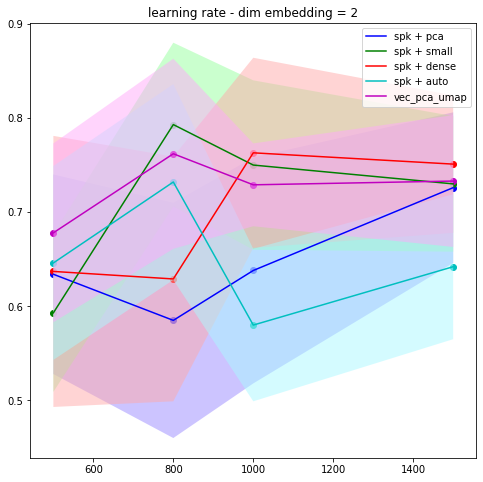

In [143]:
#visualizators = [vis_500_compx15, vis_800_compx15,vis_1000_compx15,vis_1000_compx15]
visualizators = [vis_100_noLDP, vis_500_noLDP,vis_800_noLDP,vis_1000_noLDP]
print("NO LDP")
tmp_plot(visualizators, 2)
tmp_plot_std(visualizators, 2)

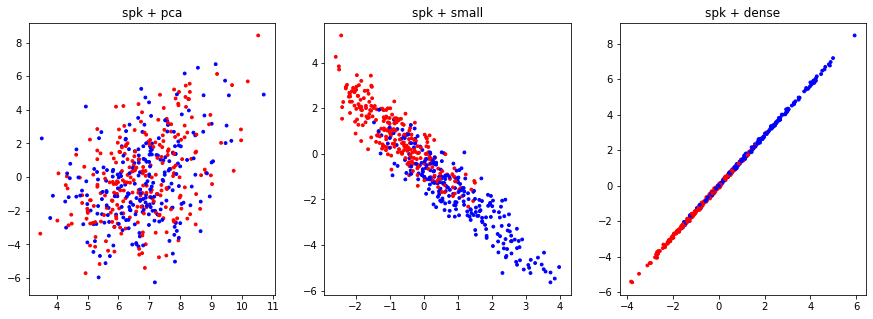

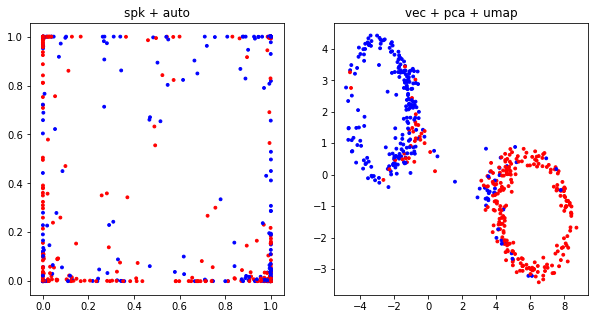

In [209]:
import matplotlib
colors = ['red','blue']




plt.figure(figsize=(15,5))
res = emb[0].transform(graphs[1:500])
lab = labels[1:500]
x = res[:,0]
y = res[:,1]
plt.subplot(1,3,1)
plt.title("spk + pca")
plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


res = emb[1].transform(graphs[1:500])
lab = labels[1:500]
x = res[:,0]
y = res[:,1]
plt.subplot(1,3,2)
plt.title("spk + small")
plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


res = emb[2].transform(graphs[1:500])
lab = labels[1:500]
x = res[:,0]
y = res[:,1]
plt.subplot(1,3,3)
plt.title("spk + dense")
plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))
plt.show()


plt.figure(figsize=(10,5))
res = emb[3].transform(graphs[1:500])
lab = labels[1:500]
x = res[:,0]
y = res[:,1]
plt.subplot(1,2,1)
plt.title("spk + auto")
plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


res = emb[4].transform(graphs[1:500])
lab = labels[1:500]
x = res[:,0]
y = res[:,1]
plt.subplot(1,2,2)
plt.title("vec + pca + umap")
plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))



In [210]:
import dill
dill.dump_session('test_tutti.db')

In [83]:
def tmp_preprocessing_vectorize(graphs):        

    for g in graphs:
        
        c=0
        for n in g.nodes():
            a = g.nodes[n]['vec']
            del g.nodes[n]['vec']
            g.nodes[n]['label'] = str(a[0])
            g.nodes[n]['vec'] = a
            c=c+1

    for g in graphs:
        c=0
        for n in g.edges():
            a = g.edges[n]['vec']
            del g.edges[n]['vec']      
            g.edges[n]['label'] = str(a[0])
            g.edges[n]['vec'] = a[0]
            c=c+1

    return(graphs)


import matplotlib.pyplot as plt
def tmp_plot(visualizators,dim_embedding):
    pos = 1
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 2
    if (dim_embedding == 5):
        pos = 3

    spk_pca = []
    spk_small = []
    spk_dense = []
    spk_auto = []
    vect_pca_umap = []

    for v in visualizators:
        result_matrix = v.summary(std=False,return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_small.append(result_matrix[1][pos])
        spk_dense.append(result_matrix[2][pos])
        spk_auto.append(result_matrix[3][pos])
        vect_pca_umap.append(result_matrix[4][pos])

    a = [500,800,1000,1500]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    plt.legend()

In [84]:


def tmp_plot_std(visualizators,dim_embedding):
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 3
    if (dim_embedding == 5):
        pos = 5



    spk_pca = []
    spk_pca_std = []
    spk_small = []
    spk_small_std = []
    spk_dense = []
    spk_dense_std = []
    spk_auto = []
    spk_auto_std = []
    vect_pca_umap = []
    vect_pca_umap_std = []

    for v in visualizators:
        result_matrix = v.summary(return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_pca_std.append(result_matrix[0][pos+1])
        spk_small.append(result_matrix[1][pos])
        spk_small_std.append(result_matrix[1][pos+1])
        spk_dense.append(result_matrix[2][pos])
        spk_dense_std.append(result_matrix[2][pos+1])
        spk_auto.append(result_matrix[3][pos])
        spk_auto_std.append(result_matrix[3][pos+1])
        vect_pca_umap.append(result_matrix[4][pos])
        vect_pca_umap_std.append(result_matrix[4][pos+1])


    a = [500,800,1000,1500]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    low = [spk_pca[i]-spk_pca_std[i] for i in range(0,len(spk_pca))]
    upp = [spk_pca[i]+spk_pca_std[i] for i in range(0,len(spk_pca))]
    plt.fill_between(a, low,upp, facecolor='#9B8BFF', alpha=0.5)

    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    low = [spk_small[i]-spk_small_std[i] for i in range(0,len(spk_small))]
    upp = [spk_small[i]+spk_small_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#97ff9f', alpha=0.5)

    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    low = [spk_dense[i]-spk_dense_std[i] for i in range(0,len(spk_small))]
    upp = [spk_dense[i]+spk_dense_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaaaa', alpha=0.5)

    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    low = [spk_auto[i]-spk_auto_std[i] for i in range(0,len(spk_small))]
    upp = [spk_auto[i]+spk_auto_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#aaf9ff', alpha=0.5)
    vect_pca_umap_std

    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    low = [vect_pca_umap[i]-vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    upp = [vect_pca_umap[i]+vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaafb', alpha=0.5)


    plt.legend()

# Experiments

In [59]:
times = 3

In [60]:
vis_2000_compx15 = utilities.repeat_n_times(graphs, labels, [emb_1,emb_2,emb_3,emb_4,emb_5], [2,3,5], times,test_size=0.3,seed = 11)
# 14:39

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
85
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 iteration n: 2
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
93
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Ve

In [49]:
vis_800_compx15 = utilities.repeat_n_times(graphs, labels, [emb_1,emb_2,emb_3,emb_4,emb_5], [2,3,5], times,test_size=0.3,seed = 11)
# 14:24
# 14:37

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
72
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
51
	 	 	  Vectorize-5, PCA-1000, UMAP
	 iteration n: 2
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Ve

In [27]:
vis_500_compx15 = utilities.repeat_n_times(graphs, labels, [emb_1,emb_2,emb_3,emb_4,emb_5], [2,3,5], times,test_size=0.3,seed = 11)
# 12.31

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
56
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 iteration n: 2
	 	 dim:  2
	 	 	  Spektral + PCA
48
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  3
	 	 	  Spektral + PCA
78
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  Vectorize-5, PCA-1000, UMAP
	 	 dim:  5
	 	 	  Spektral + PCA
0
	 	 	  Spektral + small
0
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
0
	 	 	  V

In [61]:
print("\t 500 grafi")
vis_500_compx15.summary(std = False)
vis_500_compx15.summary()
print("\n \n RANK")
vis_500_compx15.rank()

print("\n \n \n")
print("\t 800 grafi")
vis_800_compx15.summary(std = False)
vis_800_compx15.summary()
print("\n \n RANK")
vis_500_compx15.rank()

print("\n \n \n")
print("\t 1000 grafi")
vis_1000_compx15.summary(std = False)
vis_1000_compx15.summary()
print("\n \n RANK")
vis_1000_compx15.rank()

print("\n \n \n")
print("\t 2000 grafi")
vis_2000_compx15.summary(std = False)
vis_2000_compx15.summary()
print("\n \n RANK")
vis_2000_compx15.rank()


	 500 grafi
                                      2      3      5    mean
--------------------------------  -----  -----  -----  ------
Spektral + PCA                    0.747  0.754  0.758   0.753
Spektral + small                  0.77   0.647  0.762   0.726
Spektral + dense                  0.567  0.737  0.742   0.682
Spketral 128 - Autoencoder denso  0.613  0.597  0.645   0.618
Vectorize-5, PCA-1000, UMAP       0.781  0.785  0.798   0.788
                                      2    STD      3    STD      5    STD    mean
--------------------------------  -----  -----  -----  -----  -----  -----  ------
Spektral + PCA                    0.747  0.111  0.754  0.108  0.758  0.117   0.433
Spektral + small                  0.77   0.108  0.647  0.143  0.762  0.084   0.419
Spektral + dense                  0.567  0.117  0.737  0.101  0.742  0.09    0.392
Spketral 128 - Autoencoder denso  0.613  0.128  0.597  0.119  0.645  0.116   0.37
Vectorize-5, PCA-1000, UMAP       0.781  0.091  0.785  0.

In [62]:
print("\t 500 grafi")
vis_500_compx15.rank()

print("\n \n \n")
vis_500_compx15.rank()

print("\n \n \n")
vis_1000_compx15.rank()

print("\n \n \n")
vis_2000_compx15.rank()


	 500 grafi
                                    2    3    5     mean
--------------------------------  ---  ---  ---  -------
Spektral + PCA                      3    2    3  2.66667
Spektral + small                    2    4    2  2.66667
Spektral + dense                    5    3    4  4
Spketral 128 - Autoencoder denso    4    5    5  4.66667
Vectorize-5, PCA-1000, UMAP         1    1    1  1

 
 

                                    2    3    5     mean
--------------------------------  ---  ---  ---  -------
Spektral + PCA                      3    2    3  2.66667
Spektral + small                    2    4    2  2.66667
Spektral + dense                    5    3    4  4
Spketral 128 - Autoencoder denso    4    5    5  4.66667
Vectorize-5, PCA-1000, UMAP         1    1    1  1

 
 

                                    2    3    5     mean
--------------------------------  ---  ---  ---  -------
Spektral + PCA                      4    2    3  3
Spektral + small                    3